In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.load_utils import *
from esa.lstm_utils import *

from omegaconf import OmegaConf
from notebook_utils import launch_train_advice

import numpy as np
%matplotlib inline

architecture = 'lstm_ae'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [2]:
if os.path.exists(model_results+ '{}/'.format(architecture)):
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
else:
    os.makedirs(model_results+ '{}/'.format(architecture))
    model_list = []

In [3]:
launch_train_advice(cfg, model_list, config_file)

no model available, to train a model  switch train_model to True in the next cell 

check the configuration file in /srv/penny/FIORIRE/time_series_anomaly_detection/configuration/lstm_ae.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 100000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 0, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'lstm_ae', 'embedding_dim': 64, 'latent_dim': 100, 'n_layers_1': 1, 'n_layers_2': 1, 'no_latent': 0}

actual opt configuration is {'epochs': 200, 'lr':

In [5]:
train_model = True

In [6]:
if train_model:
    %run ../main.py --config_name $architecture

now = 2023-03-24 11:15:43.910632
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, batch_first=True)
    (enc): Linear(in_f

Evaluating: 100%|███████████████████████████████| 60/60 [00:11<00:00,  5.35it/s]
eval loss 0.21563215516507625
val_loss improved from 10000000000000000 to 0.21563215516507625, saving model  lstm_ae_sl_16_emb_64_layers_1_1_24_03_2023_11:15:43 to /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/lstm_ae
  0%|▏                                     | 1/200 [00:59<3:18:08, 59.74s/epoch]epoch num 1

  0%|                                                | 0/140 [00:00<?, ?batch/s]Loss:
0.178852379322052

  7%|██▊                                    | 10/140 [00:06<01:07,  1.92batch/s]Loss:
0.17182470858097076

 14%|█████▌                                 | 20/140 [00:09<00:37,  3.23batch/s]Loss:
0.16504985094070435

 21%|████████▎                              | 30/140 [00:12<00:31,  3.49batch/s]Loss:
0.16021305322647095

 29%|███████████▏                           | 40/140 [00:24<03:17,  1.98s/batch]^C


In [7]:
if train_model:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_ae_sl_16_emb_64_layers_1_1_24_03_2023_11:15:43.pth


In [8]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
if len(model_list) > 0:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
    model_available = True
else:
    print('no model available')

lstm_ae_sl_16_emb_64_layers_1_1_24_03_2023_11:15:43.pth


In [ ]:
selected_model = 0
if model_available:
    print(model_list[selected_model])
    model_name = model_list[selected_model].split('.')[0]
else:
    print('no model available')

In [9]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [10]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model],
                        map_location=device)
params_conf = checkpoint['param_conf']

In [11]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
    
out_window = params_conf['out_window']

latent_dim = params_conf['latent_dim']
seq_len = params_conf['sequence_length']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
try:
    no_latent = params_conf['no_latent']
except:
    no_latent = False
shuffle = False

data_path = params_conf['data_path']

In [12]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], 
             transform=transform)    

In [13]:
model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=len(params_conf['target']),
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']
                , no_latent = no_latent)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, batch_first=True)
    (enc): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(100, 64, batch_first=True)
    (LSTM1): LSTM(64, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=16, bias=True)
  )
)
number of params 274804


In [14]:
compute_mse_val_loss = False

In [15]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [16]:
num_batch = 10
inject_anomalies = False

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 9051


In [17]:
x, enc, yo = model(x.to(device))
if inject_anomalies:
    xa, enc, ya = model(xa.to(device))
save = False

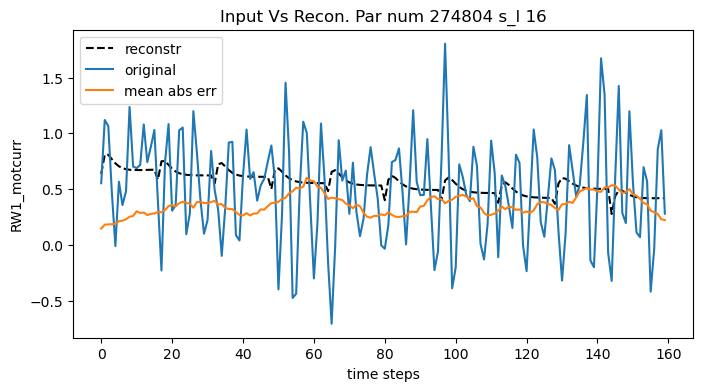

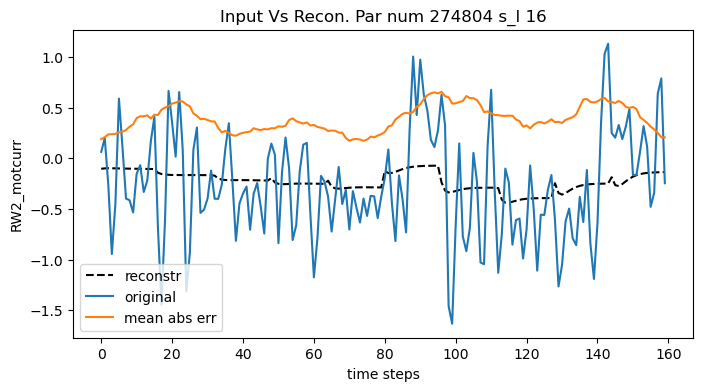

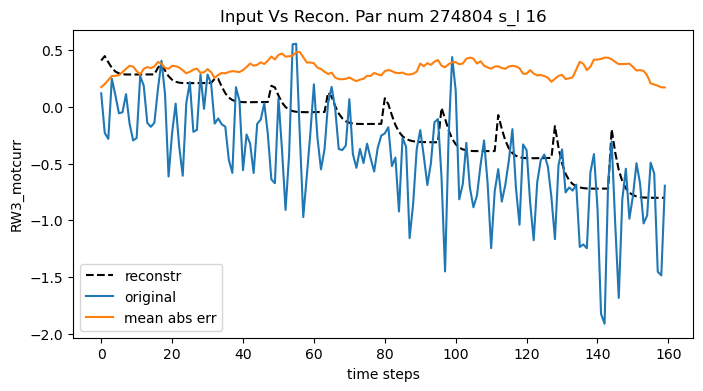

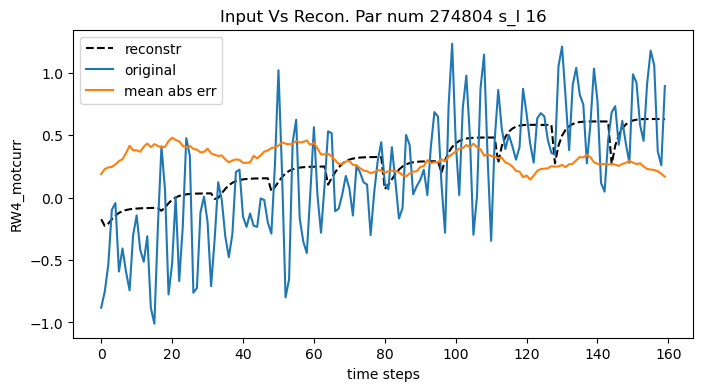

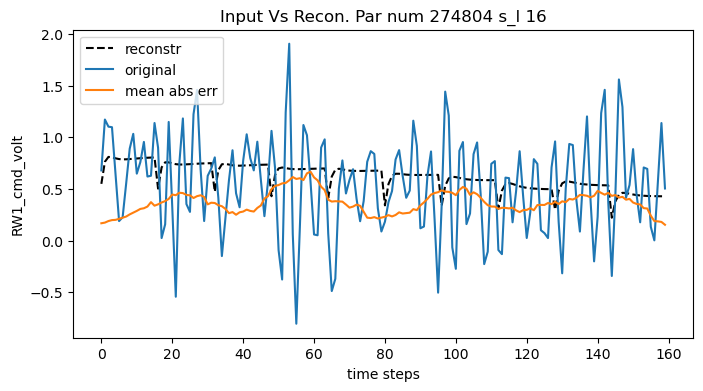

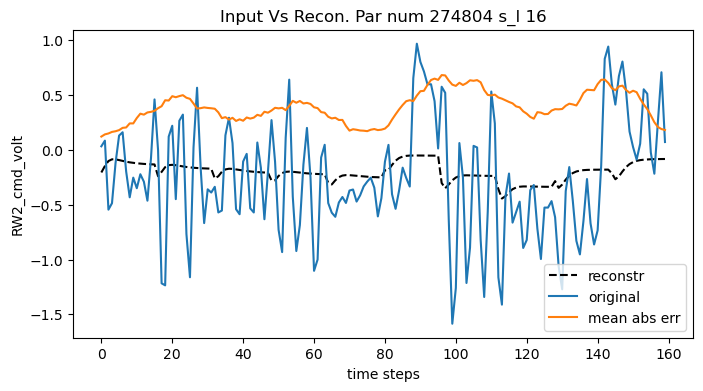

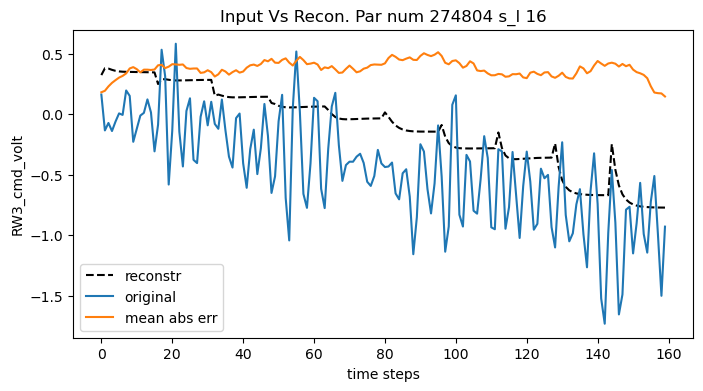

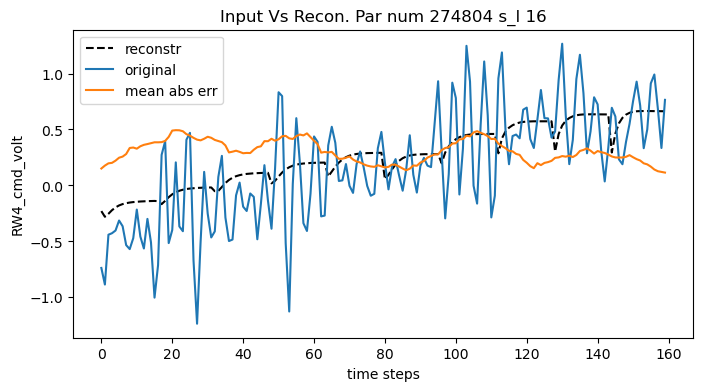

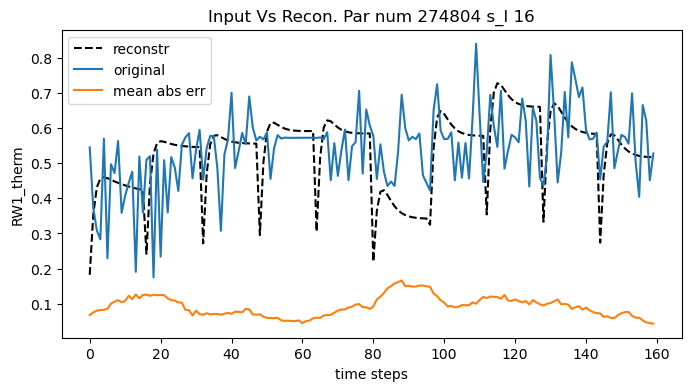

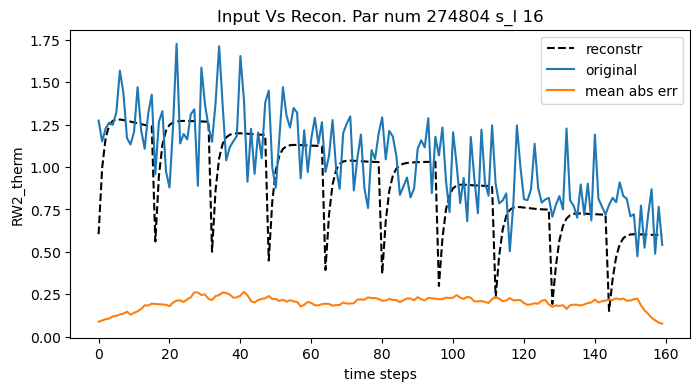

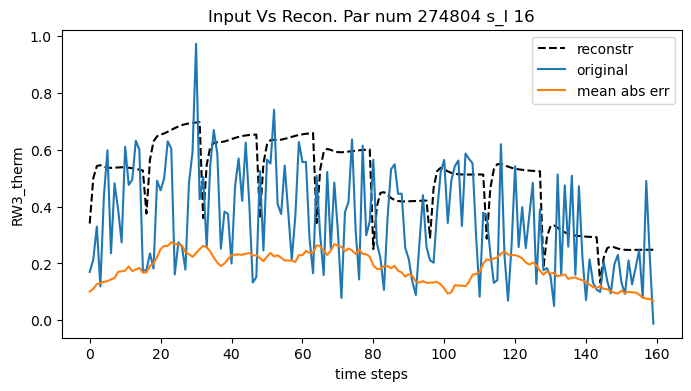

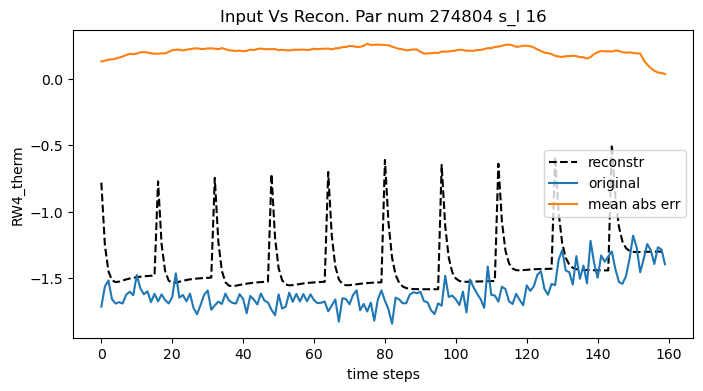

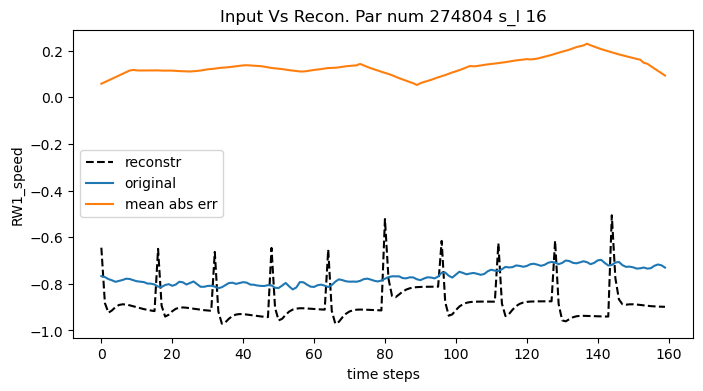

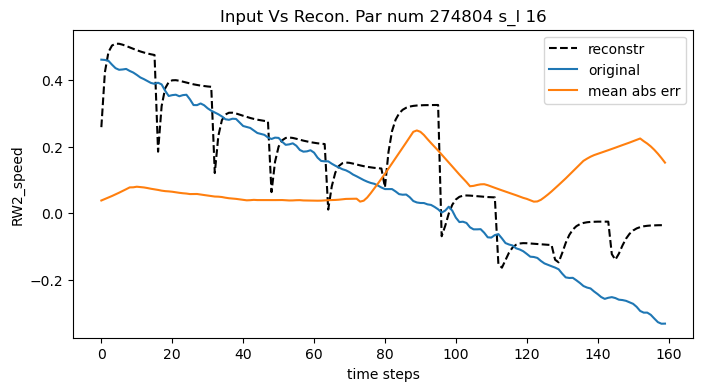

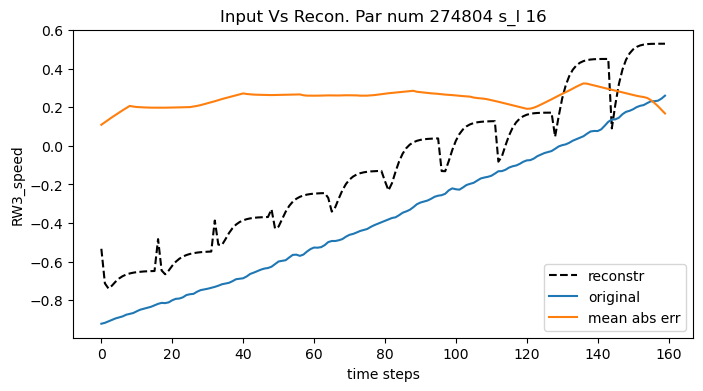

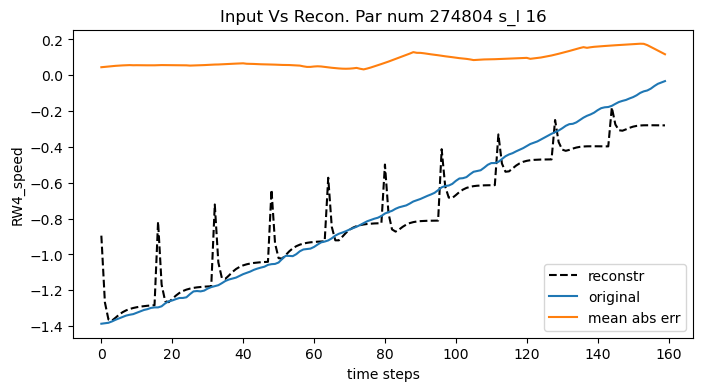

In [18]:
show_results(x, yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,architecture=architecture,save=False)